# GADMA with custom model

GADMA could be run with a detailed specified demographic model. Model should be provided as a file with a function ``model_func`` that describes demographic history by engine itself. It should take values of parameters and other required arguments and return simulated data for demographic history with those parameters.

For example, let us use ``moments`` as the engine for demographic inference. We have data for two populations of Gillette butterfly from [McCoy et al. 2013](https://onlinelibrary.wiley.com/doi/10.1111/mec.12591) and we want to estimate demographic history with population split, constant sizes of populations and asymmetric migrations.

We will need moments to show plots of our data:

In [1]:
import moments

## Data

We have two populations of checkerspot butterfly *Euphydryas gillettii*:

* WY - native population in Wyoming,
* CO - population from Colorado.

Folded AFS was built from all SNPs and has a size of 13x13.

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


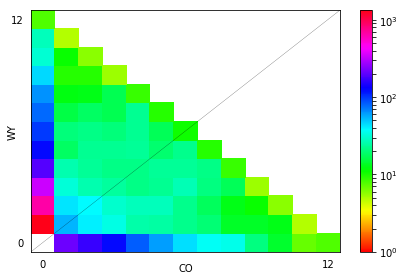

In [2]:
data = moments.Spectrum.from_file("2pop_e_gillettii_all_snp.fs")
ns = data.sample_sizes
moments.Plotting.plot_single_2d_sfs(data, vmin=1.0)

## Demographic model

Demographic model was built according to the original paper: the ancestral population of constant size split into two populations of new constant sizes and there was asymmetric continuous migration between those populations.

Code of this model is already in file ``demographic_model.py`` and is written according to [``moments`` manual](https://bitbucket.org/simongravel/moments/src/master/doc/manual/manual.pdf).

In [3]:
%%bash
cat demographic_model.py

import moments
import numpy as np

def model_func(params, ns):
    nuW, nuC, T, m12, m21 = params
    sfs = moments.LinearSystem_1D.steady_state_1D(sum(ns))
    fs = moments.Spectrum(sfs)

    fs = moments.Manips.split_1D_to_2D(fs, ns[0], sum(ns[1:]))

    m = np.array([[0, m12], [m21, 0]])
    fs.integrate(Npop=[nuW, nuC], tf=T, m=m, dt_fac=0.1)
    return fs


We could use some random parameters to plot this demographic model:

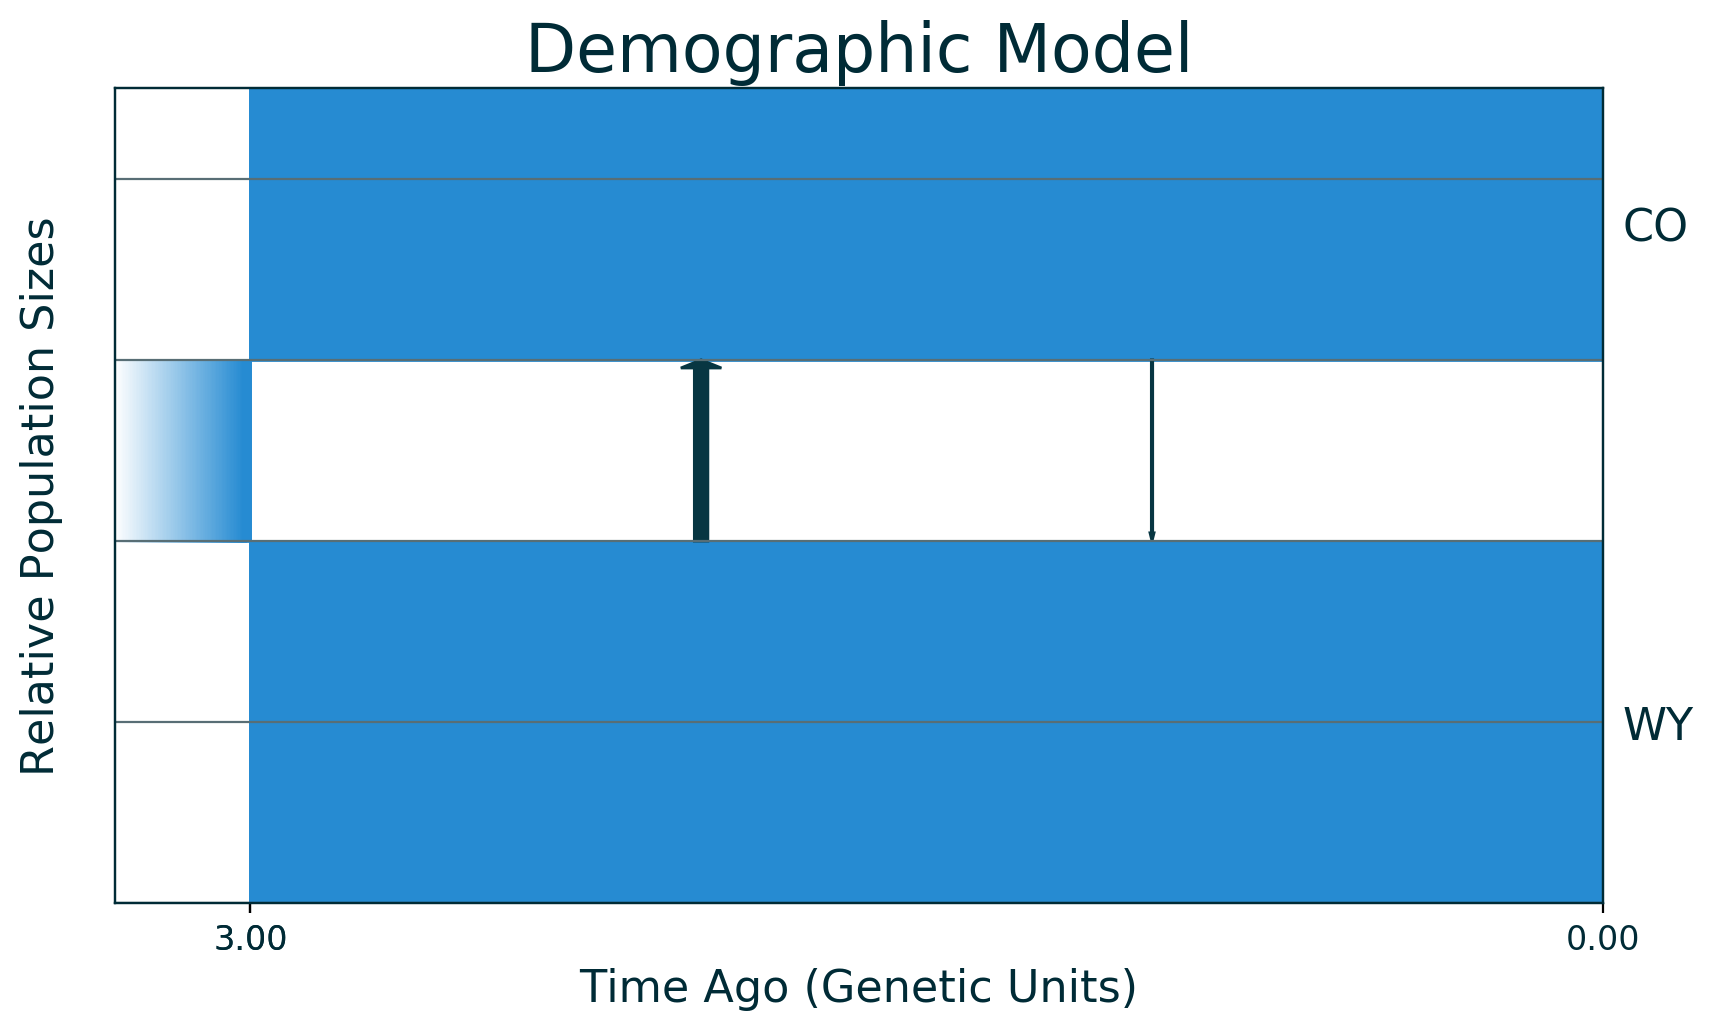

In [4]:
from demographic_model import model_func
rand_pars = [2, 1.5, 3, 0.1, 1]
model = moments.ModelPlot.generate_model(model_func, rand_pars, ns)
moments.ModelPlot.plot_model(model,
                             pop_labels=['WY', 'CO'],
                             draw_scale=False,
                             reverse_timeline=True)

## Inference with GADMA

To run GADMA with custom model one should set parameters file:

In [1]:
%%bash
cat params_file

# Set data first
Input file: 2pop_e_gillettii_all_snp.fs

# Some additional settings for data but we do not use them here:
#
# Population labels: WY, CO  # we could change order of populations
# Projections: 10, 10  # downsamples AFS
# Outgroup: False  # indicates if there is outgroup in data


# Output folder. It should be empty.
Output directory: gadma_result


# Set engine for simulations. We use default moments.
Engine: moments


# Now set our custom demographic model from file.
# There should be a function model_func in the file with a model.
Custom filename: demographic_model.py

# We could set optional settings about parameter labels,
# lower and upper bounds. But GADMA can extract it from provided
# file with model. If it fail then error will be printed and one
# should set at least parameter labels here.
#
# Parameter labels: nuW, nuC, T, m12, m21
# Lower bound: 1e-2, 1e-2, 1e-15, 0, 0
# Upper bound: 100, 100, 5, 10, 10


# How many repeats to run and how many processes to use

In [6]:
%%bash
# As output directory should be empty we remove it if it exists
rm -rf gadma_result

Now we could run GADMA:

In [7]:
%%bash
gadma -p params_file

--Successful arguments parsing--

Data reading
Number of populations: 2
Projections: [12 12]
Population labels: ['WY', 'CO']
Outgroup: False
--Successful data reading--

Parameters of launch are saved in output directory: /home/katenos/Workspace/popgen/GADMA/examples/custom_model/gadma_result/params_file
All output is saved in output directory: /home/katenos/Workspace/popgen/GADMA/examples/custom_model/gadma_result/GADMA.log
--Start pipeline--
Run launch number 1
Run launch number 2

[000:01:00]
All best by log-likelihood models
Number	log-likelihood	Model
Run 1	-286.68	(nuW=1.30539,	nuC=0.22743,	T=0.16273,	m12=0.62013,	m21=0)	c	(theta =  1333.14)
Run 2	-337.37	(nuW=1.62871,	nuC=0.24435,	T=1.24862,	m12=0.73595,	m21=1.4779)	m	(theta =  962.87)

You can find picture and python code of best model in the output directory.

Finish genetic algorithm number 2

[000:02:00]
All best by log-likelihood models
Number	log-likelihood	Model
Run 1	-282.81	(nuW=1.2634,	nuC=0.18067,	T=0.12439,	m12=0.279

The run was fast because we have a small size of data and a low number of parameters. Also usually one should run a lot of repeats: we have 2 here (50 is better for example).

## Output directory

Now let us look at the output directory. Short descriptions:

* `1` - directory with output of first repeat.
    - `GADMA_GA.log` - log of run.
    - `current_best_logLL_model_moments_code.py` - the last best by log-likelihood model.
    - `final_best_logLL_model_moments_code.py` - The final best by log-likelihood model.
    - `eval_file` - File with all evaluations.
    - `save_file` - File with saved info about run.
* `2` - directory with output of second repeat.
* `GADMA.log` - the output of base run.
* `best_logLL_model_moments_code.py` - result best model.
* `best_logLL_model.png` - picture of best model.
* `params_file` - settings of the base run.
* `extra_params_file` - extra settings of the base run.

In [8]:
%%bash
tree gadma_result
# If you do not have tree:
# ls gadma_result

gadma_result
├── 1
│   ├── current_best_logLL_model_moments_code.py
│   ├── eval_file
│   ├── final_best_logLL_model_moments_code.py
│   ├── final_best_logLL_model.png
│   ├── GADMA_GA.log
│   └── save_file
├── 2
│   ├── current_best_logLL_model_moments_code.py
│   ├── eval_file
│   ├── final_best_logLL_model_moments_code.py
│   ├── final_best_logLL_model.png
│   ├── GADMA_GA.log
│   └── save_file
├── best_logLL_model_moments_code.py
├── best_logLL_model.png
├── extra_params_file
├── GADMA.log
└── params_file

2 directories, 17 files


In [9]:
%%bash
# GADMA.log contains the same output we have during run. Let us see last lines again:
tail -n 19 gadma_result/GADMA.log


[000:02:30]
All best by log-likelihood models
Number	log-likelihood	Model
Run 1	-282.81	(nuW=1.2634,	nuC=0.18067,	T=0.12439,	m12=0.27997,	m21=0.00e+00)	m	(theta =  1380.39)
Run 2	-337.22	(nuW=3.65368,	nuC=0.57561,	T=4.98909,	m12=0.33304,	m21=0.61661)	(theta =  421.42)

You can find picture and python code of best model in the output directory.


--Finish pipeline--


You didn't specify theta at the beginning. If you want change it and rescale parameters, please see tutorial.

Thank you for using GADMA!

In case of any questions or problems, please contact: ekaterina.e.noskova@gmail.com



### Plots

File best_logLL_model.png have picture of our best model:

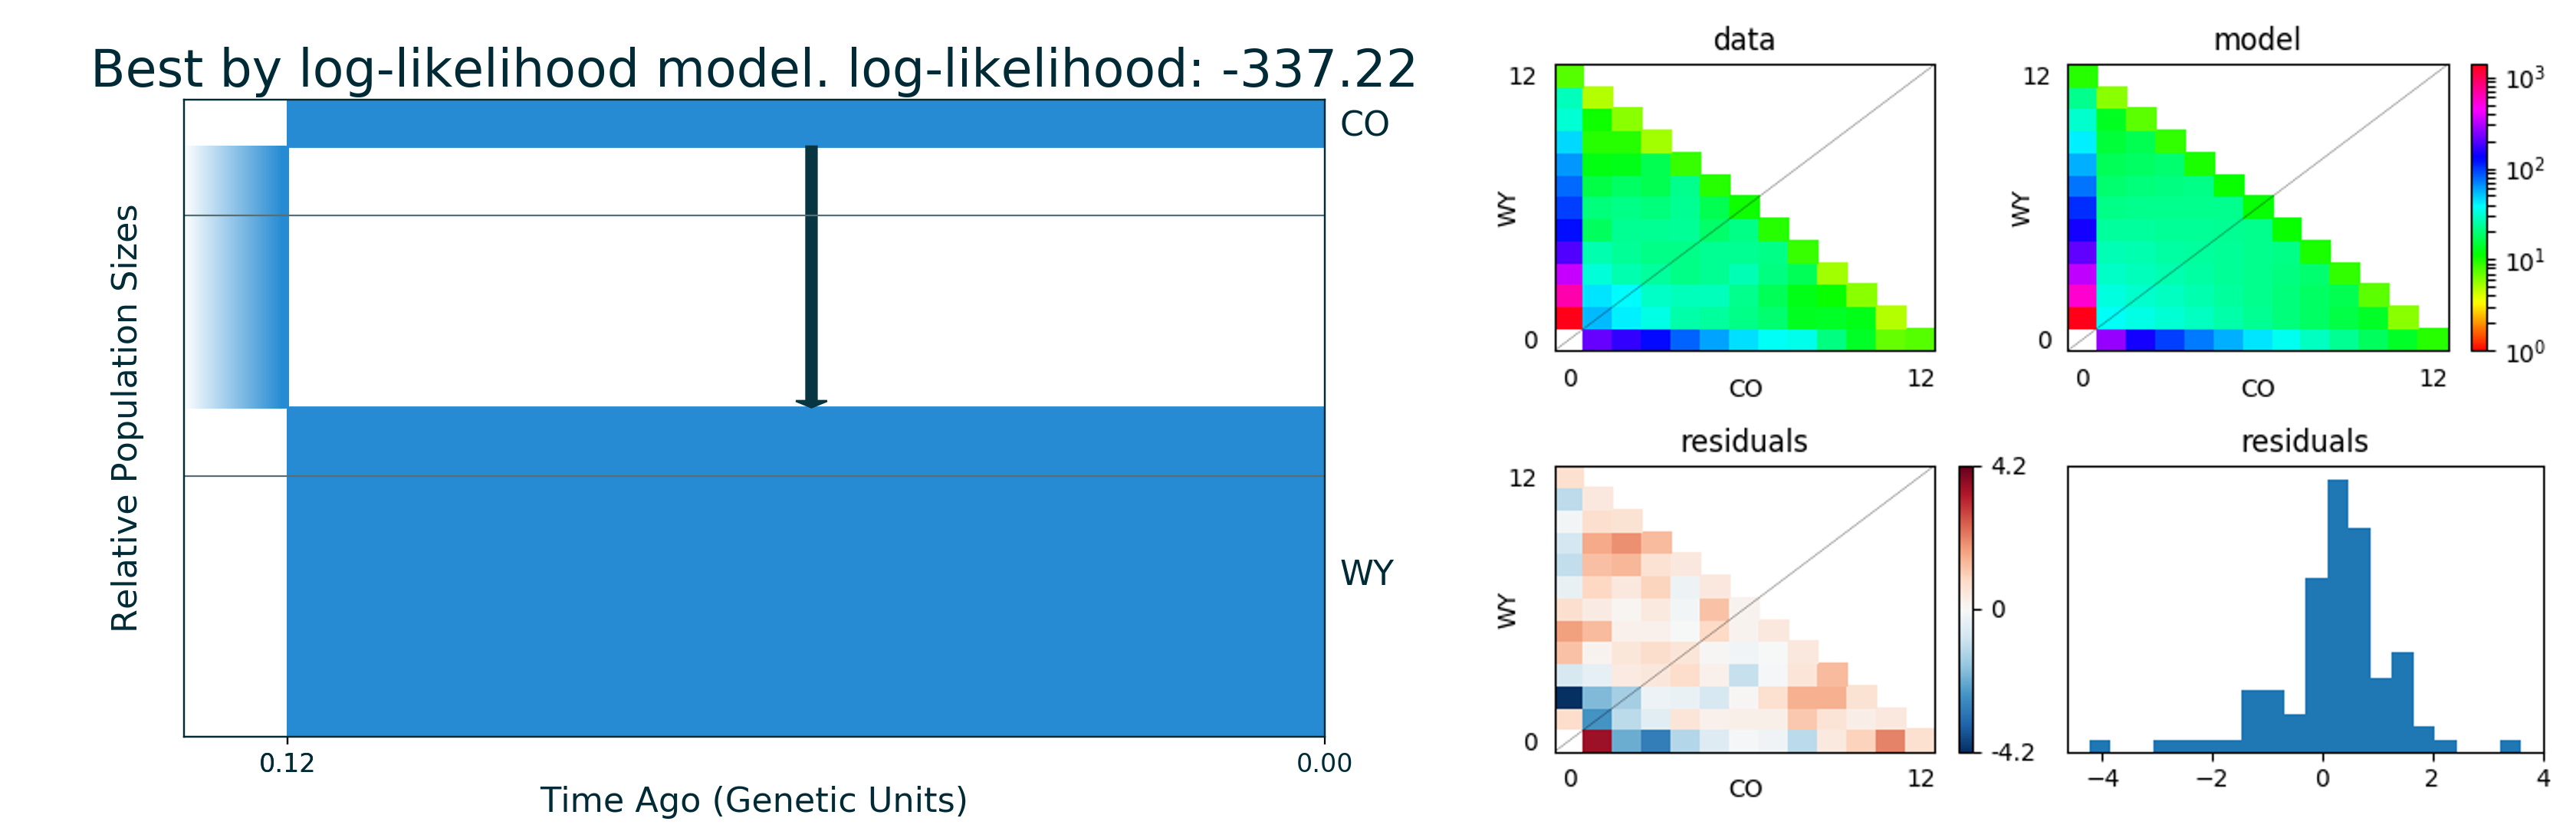

In [12]:
from IPython.display import Image
from IPython.core.display import HTML 

Image("gadma_result/best_logLL_model.png")

### Run generated code with final model

We could run the code of final model to get its log-likelihood.

In [2]:
%%bash
# Show generated code
cat gadma_result/best_logLL_model_moments_code.py

import moments
import numpy as np

import importlib.util

spec = importlib.util.spec_from_file_location('module', 'demographic_model.py')
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)
model_func = module.model_func


data = moments.Spectrum.from_file('2pop_e_gillettii_all_snp.fs')
ns = data.sample_sizes

p0 = [1.2634029664716868, 0.18066683184484178, 0.12439006690470482, 0.2799706652520448, 0.0]
model = model_func(p0, ns)
ll_model = moments.Inference.ll_multinom(model, data)
print('Model log likelihood (LL(model, data)): {0}'.format(ll_model))

theta = moments.Inference.optimal_sfs_scaling(model, data)
print('Optimal value of theta: {0}'.format(theta))
Nanc = None


plot_ns = [4 for _ in ns]  # small sizes for fast drawing
gen_mod = moments.ModelPlot.generate_model(model_func,
                                           p0, plot_ns)
moments.ModelPlot.plot_model(gen_mod,
                             save_file='model_from_GADMA.png',
                      

In [11]:
%%bash
# Run generated code
python3 gadma_result/best_logLL_model_moments_code.py

Model log likelihood (LL(model, data)): -282.8121911840898
Optimal value of theta: 1380.387312259496


After run of generated code new plot of model is saved to `model_from_GADMA.png`:

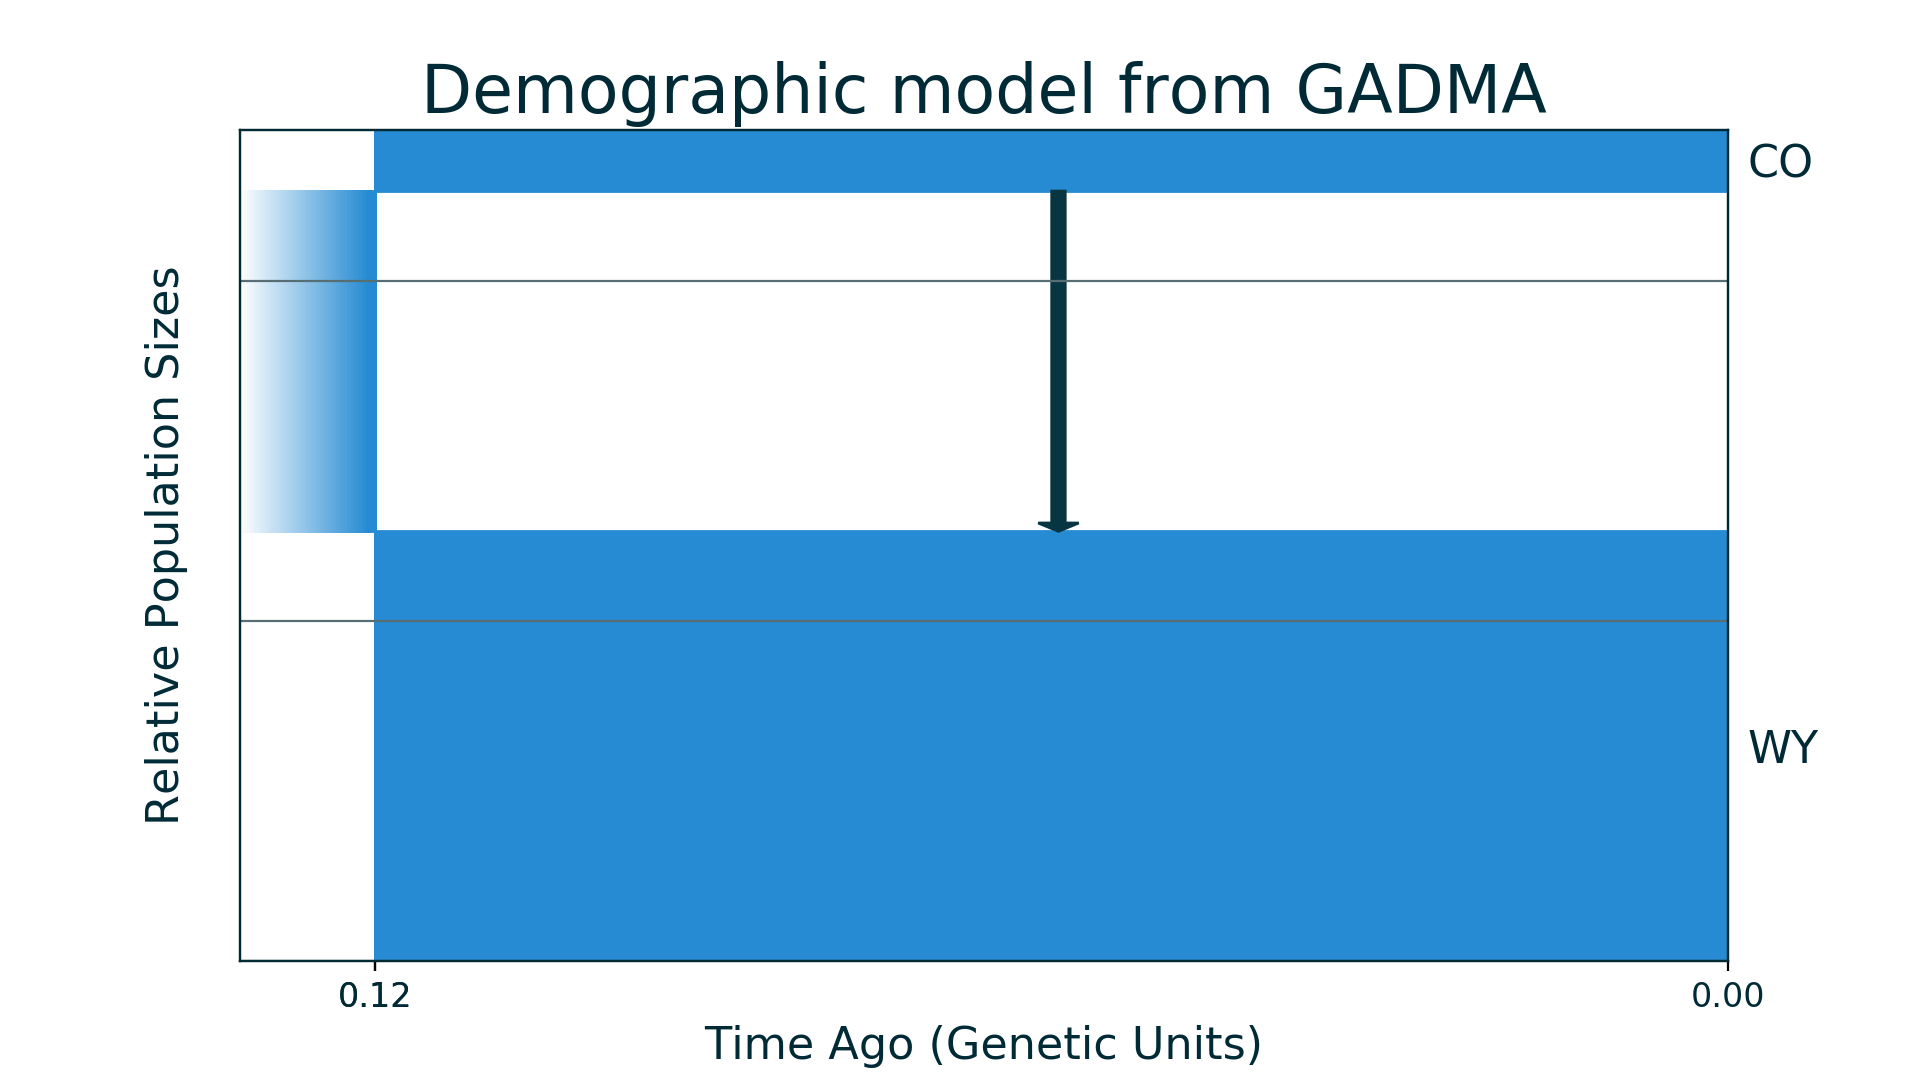

In [13]:
Image("model_from_GADMA.png")